In [1]:
# example string to do mini tests on
example = "I just EASILY had the BEST lunch I've ever eaten!  It was THAT good!\n\nThe chicken tortilla soup was out of this world...light and delicate...fresh and HOT!!!\nI had two fish tacos with no tortilla.  One was a regular fish taco and the other was a beer battered fish taco.l\n\nThe fire roasted salsa was EASILY the best salsa I have ever had, too!\n\nThis place is a serious gem!  I could go there every single day!\n\nThanks guys!!"

# Import Benepar


In [2]:
import benepar
benepar.download("benepar_en2")
parser = benepar.Parser("benepar_en2")

/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

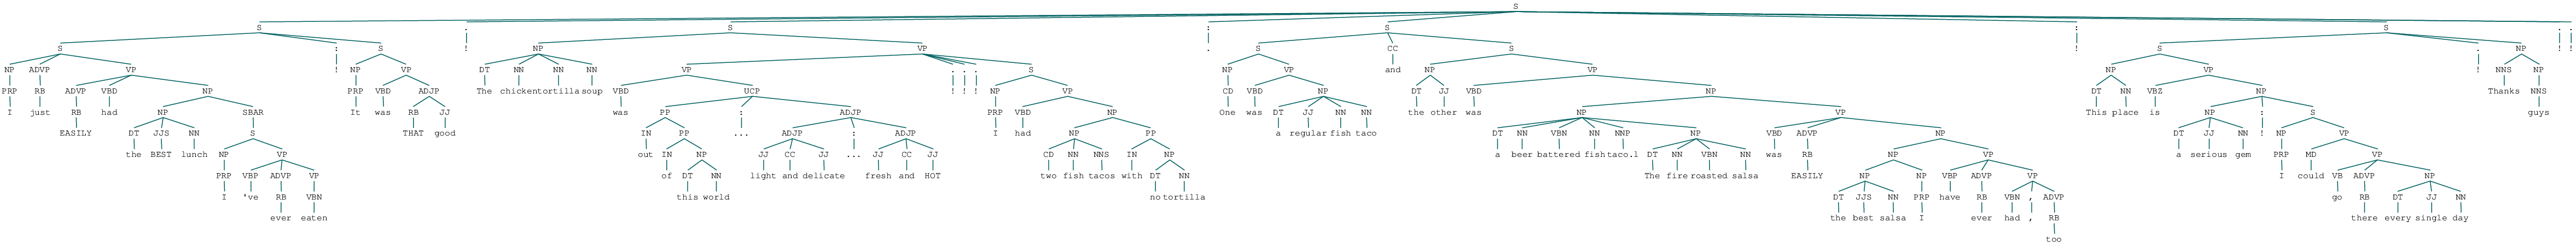

In [3]:
parser.parse(example)

# Import StanfordNLP

Remember to first instantiate stanfordNLP in java!

java command: 

``
java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -annotators "tokenize,ssplit,pos,lemma,parse,sentiment" -sentiment.threads 8 -port 9000 -timeout 30000``


In [3]:
import stanfordnlp
from stanfordcorenlp import StanfordCoreNLP
import logging
import json

class StanfordNLP:
    def __init__(self, host='http://localhost', port=9000):
        self.nlp = StanfordCoreNLP(host, port=port,
                                   timeout=30000)  # , quiet=False, logging_level=logging.DEBUG)
        self.props = {
            'annotators': 'tokenize,ssplit,pos,lemma,ner,parse,depparse,dcoref,relation',
            'pipelineLanguage': 'en',
            'outputFormat': 'json'
        }

    def word_tokenize(self, sentence):
        return self.nlp.word_tokenize(sentence)

    def pos(self, sentence):
        return self.nlp.pos_tag(sentence)

    def ner(self, sentence):
        return self.nlp.ner(sentence)

    def parse(self, sentence):
        return self.nlp.parse(sentence)

    def dependency_parse(self, sentence):
        return self.nlp.dependency_parse(sentence)

    def annotate(self, sentence):
        return json.loads(self.nlp.annotate(sentence, properties=self.props))

    @staticmethod
    def tokens_to_dict(_tokens):
        tokens = defaultdict(dict)
        for token in _tokens:
            tokens[int(token['index'])] = {
                'word': token['word'],
                'lemma': token['lemma'],
                'pos': token['pos'],
                'ner': token['ner']
            }
        return tokens

    

sNLP = StanfordNLP()
text = 'A blog post using Stanford CoreNLP Server. Visit www.khalidalnajjar.com for more details.'
print("Parse:", sNLP.parse(text))

Parse: (ROOT
  (S
    (NP (DT A) (NN blog))
    (VP (NN post)
      (S
        (VP (VBG using)
          (NP (NNP Stanford) (NNP CoreNLP) (NN Server)))))
    (. .)))


# Import Entity Recognition Model

In [4]:
import spacy

model_dir = "./models"
nlp = spacy.load(model_dir)

In [5]:
def get_entities(nlp_model, text):
    """
    Input nlp_model and text, retrieve a list of unique entities from the text.
    """
    doc = nlp_model(text)
    entities = set()
    for ent in doc.ents:
        if ent.label_ == "PRODUCT":
            entities.add(ent.text)
    return list(entities)

In [6]:
example_entity_list = get_entities(nlp, example)
example_entity_list

['taco',
 'salsa',
 'soup',
 'chicken',
 'place',
 'lunch',
 'beer',
 'fish',
 'tortilla',
 'gem']

In [7]:
#quick fix
#example_entity_list = ['chicken tortilla soup', 'fish tacos', 'tortilla', 'beer battered fish taco', 'fire roasted salasa', 'place']

In [8]:
example

"I just EASILY had the BEST lunch I've ever eaten!  It was THAT good!\n\nThe chicken tortilla soup was out of this world...light and delicate...fresh and HOT!!!\nI had two fish tacos with no tortilla.  One was a regular fish taco and the other was a beer battered fish taco.l\n\nThe fire roasted salsa was EASILY the best salsa I have ever had, too!\n\nThis place is a serious gem!  I could go there every single day!\n\nThanks guys!!"

# Sentiment Helper Code

In [200]:
import collections
import re

def remove_nestings(lst): 
    output = []
    
    def remove_nestings_recursive(l):
        for i in l: 
            if type(i) == list: 
                remove_nestings_recursive(i) 
            else: 
                output.append(i)
    
    remove_nestings_recursive(lst)
    
    return output

def continue_splitting(review,list_of_dividers):
        
    temp = list_of_dividers.copy()
    l = [review]
    while len(temp) > 0:
        divider = temp.pop(0)
        l_new = []
        for i in l:
            l_new += i.split(divider)
        l = l_new
    return l

def join_clause(review, list_of_split_clauses, list_of_dividers):
    output = []
    loc_of_split_clauses = []
    for clause in list_of_split_clauses:
        loc_of_split_clauses.append(review.find(clause))
    for divider in list_of_dividers:
        print(divider)
        loc_div = review.find(divider)
        print(loc_div)
        for i in range(len(loc_of_split_clauses)):
            if loc_div > loc_of_split_clauses[i]:
                print(loc_div,loc_of_split_clauses[i])
                
def join_partitions(long_review,entity_with_review):
    loclist = []
    for (_, clause) in entity_with_review:
        loclist.append((long_review.find(clause),long_review.find(clause)+len(clause)))
    starts = {i for (i,j) in loclist}
    ends = {j for (i,j) in loclist}
    starts.add(len(long_review))
    newends = {}
    for i in ends:
        newends[i] = min([x for x in starts if x >= i])
    for i in newends:
        pass
    new_entity_with_review = []
    for i in range(len(loclist)):
        tup = loclist[i]
        entity = entity_with_review[i][0]
        st = tup[0]
        en = newends[tup[1]]
        new_entity_with_review.append((entity,long_review[st:en]))
    return new_entity_with_review

def split_long_string(review):
    num = len(review)
    split_list = []
    start = 0
    end = 0
    while num != end:
        if num - end < 1000:
            end = num
            split_list.append(review[start:end])
        else:
            end = review[start:(start+1000)].rfind('.')
            if end == -1:
                end = review[start:(start+1000)].rfind(' ') #if no '.', space will do
                if end == -1:
                    end = min(start + 1000,num)
            split_list.append(review[start:end])
            start = end
    print(start,end)
    return(split_list)

def split_review_naive(review,entities):
    clauses = re.split('[.?!]',review)
    lenlist = [len(x) for x in clauses]
    clauses = [x for _, x in sorted(zip(lenlist,clauses),reverse=False)]
    entity_with_clause = []
    for entity in entities:
        for clause in clauses:
            if entity in clause:
                entity_with_clause.append((entity,clause))
                break
    return(join_partitions(review,entity_with_clause))

def min_tree(review, entities, parser, output = 'minimum'):
    
    #review is string, entities is list of strings, parser is parser object
    # TODO: How well are each review punctuatd and so forth EDA
    if output == 'partition':
        full_review = ''
        
    treelist = []
    lenlist = []
    temp = review.split('\n')
    
    if output == 'no_parse':
        return(split_review_naive(review,entities))
    
    if len(review) > 1000:
        split_reviews = split_long_string(review)
    else:
        split_reviews = [i for i in temp if len(i) > 1 and len(i) <= 1000 ]
    
    for rev in split_reviews:
        if rev and rev.strip():
            u = parser.parse(rev) # tree 

            if type(u) == str:
                u = nltk.Tree.fromstring(u)

            for s in u.subtrees(): # subtrees 
                if s.label() == 'S': # if sentence
                    treelist += [s]
                    lenlist += [len(s.leaves())] # how long clause
                        
            if output == 'partition':
                full_review += ' '.join(u.leaves()) + ' '

    treelist = [x for _, x in sorted(zip(lenlist,treelist),reverse=False)] # sort by lenlisit
    clauses = [' '.join(tree.leaves()) for tree in treelist]
    
    #If there is no sentences detected, then the full review is the only clause.
    if not clauses:
        if output == 'partition':
            clauses.append(full_review)
        else:
            clauses.append(review)
    entity_with_clause = []
    
    if output == 'all':
        for entity in entities:
            clauselist = []
            for clause in clauses:
                if entity in clause:
                    clauselist.append(clause)
            entity_with_clause.append((entity,clauselist))
    
    #TODO: create rules and test them
    elif output == 'minimum':
        for entity in entities:
            for clause in clauses:
                if entity in clause:
                    entity_with_clause.append((entity,clause))
                    break
                    
    elif output == 'partition':
        #first find minimal clause
        for entity in entities:
            for clause in clauses:
                if entity in clause:
                    entity_with_clause.append((entity,clause))
                    break
        #get location of minimal clause in review
        
        entity_with_clause = join_partitions(full_review,entity_with_clause)
    
    return entity_with_clause

# Code to Perform Sentiment Analysis

In [10]:
#STANFORD NLP
import numpy as np
from pycorenlp import StanfordCoreNLP
def stanford_sentiment_start():
    nlp = StanfordCoreNLP('http://localhost:9000')
    return nlp

def stanford_sentiment(entity_with_clause):
    nlp = stanford_sentiment_start()
    entity_with_sentiment = []
    for entity, clause in entity_with_clause:
        result = nlp.annotate(clause,
                   properties={
                       'annotators': 'sentiment',
                       'outputFormat': 'json'
                   })
        sentiment = np.dot(result['sentences'][0]['sentimentDistribution'], [-2, -1, 0, 1, 2])
        entity_with_sentiment.append((entity, sentiment))
    return entity_with_sentiment

#VADER
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
def vader_sentiment(entity_with_clause):
    analyzer = SentimentIntensityAnalyzer()
    entity_with_sentiment = []
    for entity, clause in entity_with_clause:
        sentiment = analyzer.polarity_scores(clause)['compound']
        entity_with_sentiment.append((entity,sentiment))
    return(entity_with_sentiment)       

In [11]:
example_min_tree = min_tree(example, example_entity_list, parser, 'no_parse')
example_min_tree

[('taco', '\nI had two fish tacos with no tortilla.'),
 ('salsa',
  'l\n\nThe fire roasted salsa was EASILY the best salsa I have ever had, too!'),
 ('soup',
  '\n\nThe chicken tortilla soup was out of this world...light and delicate...fresh and HOT!!!'),
 ('chicken',
  '\n\nThe chicken tortilla soup was out of this world...light and delicate...fresh and HOT!!!'),
 ('place',
  '\n\nThis place is a serious gem!  I could go there every single day!\n\nThanks guys!!'),
 ('lunch',
  "I just EASILY had the BEST lunch I've ever eaten!  It was THAT good!"),
 ('beer',
  '  One was a regular fish taco and the other was a beer battered fish taco.'),
 ('fish', '\nI had two fish tacos with no tortilla.'),
 ('tortilla', '\nI had two fish tacos with no tortilla.'),
 ('gem',
  '\n\nThis place is a serious gem!  I could go there every single day!\n\nThanks guys!!')]

In [17]:
# need to fix stanford error here
stanford_sentiment(example_min_tree)

[('salsa', 0.35840545406733),
 ('soup', -0.45428712791411996),
 ('lunch', -0.69090491339469),
 ('beer', -0.7694083487360099),
 ('gem', 1.72169947742949),
 ('fish', -0.61599212634352),
 ('taco', -0.61599212634352),
 ('place', 1.72169947742949),
 ('tortilla', -0.61599212634352),
 ('chicken', -0.45428712791411996)]

In [12]:
def get_vader_scores(text, entity_list, parser):
    tree = min_tree(text, entity_list, parser)
    return vader_sentiment(tree)

get_vader_scores(example, example_entity_list, parser)

[('taco', 0.0),
 ('salsa', 0.7371),
 ('soup', 0.5229),
 ('chicken', 0.5229),
 ('place', -0.0772),
 ('lunch', 0.8429),
 ('beer', -0.296),
 ('fish', 0.0),
 ('tortilla', -0.296),
 ('gem', -0.0772)]

# Werk

In [178]:
def werk(review, entities, parser = [], sentiment_package = 'vader', parse_package = 'benepar', rule = 'rule_1'):
    
    #print("\nLoading Parser")
    
    #first is the parser
    if not parser and parse_package == 'benepar':
        parser = benepar.Parser("benepar_en2")
    elif not parser and parse_package == 'stanford':
        #parser = StanfordNLP('http://localhost')
        raise Exception('incorrect parse package')
    elif parser:
        pass
    else:
        raise Exception('incorrect parse package')
    
    #print("Parser =", parse_package)

        
    #second is the rule
    
    #print("\nLoading Rule")
    
    if rule == 'rule_1':
        
        #print("Rule =",rule)
        
        entity_with_review = min_tree(review, entities, parser, output = 'minimum')
        
        #print("\nTree Generated")
        
        entity_with_sentiment = sentiment_analysis(entity_with_review, sentiment_package)
        
        #print("\nSentiment Generated")

        
    elif rule == 'rule_2':
        
        #print("Rule =",rule)
        
        entity_with_review = min_tree(review, entities, parser, output = 'all')
        
        #print("\nTree Generated")
        entity_with_sentiment = []
        sentiment = 0
        for ent, revlist in entity_with_review:
            for clause in revlist:
                sentiment = sentiment_analysis_indiv(clause,sentiment_package)
                if sentiment_package == 'benepar' and abs(sentiment) != 0:
                    break
                elif sentiment_package == 'stanford' and abs(sentiment) > 0.5:
                    break
                    #if sentiment is not neutral, stop. If sentiment is neutral, keep going up tree.
            entity_with_sentiment.append((ent,sentiment))
        #print("\nSentiment Generated")        
        
    elif rule == 'rule_3':
        
        #print("Rule =",rule)
        
        entity_with_review = min_tree(review, entities, parser, output = 'all')
        
        #print("\nTree Generated")
        
        entity_with_sentiment = []
        for ent, revlist in entity_with_review:
            sentiment_list = []
            for clause in revlist:
                sentiment = sentiment_analysis_indiv(clause,sentiment_package)
                sentiment_list.append(sentiment)
            entity_with_sentiment.append((ent,np.mean(sentiment_list)))
            
        #print("\nSentiment Generated") 
        
    elif rule == 'rule_4':
        
        #print("Rule =",rule)
        
        entity_with_review = min_tree(review, entities, parser, output = 'partition')
        #print("\nTree Generated")
        
        entity_with_sentiment = sentiment_analysis(entity_with_review, sentiment_package)
        
        #print("\nSentiment Generated")
        
    elif rule == 'rule_5':
        
        #print("Rule =",rule)
        
        entity_with_review = min_tree(review, entities, parser, output = 'minimum')
        entity_with_review_p = min_tree(review, entities, parser, output = 'partition')
        #print("\nTree Generated")
        
        entity_with_sentiment = sentiment_analysis(entity_with_review, sentiment_package)
        for i in range(len(entity_with_sentiment)):
            sent = entity_with_sentiment[i][1]
            if sentiment_package == 'vader' and sent != 0:
                entity_with_sentiment[i] = (entity_with_sentiment[i][0],sentiment_analysis_indiv(entity_with_review_p[i][1],sentiment_package))
            elif sentiment_package == 'stanford' and abs(sent) > 0.5:
                entity_with_sentiment[i] = (entity_with_sentiment[i][0],sentiment_analysis_indiv(entity_with_review_p[i][1],sentiment_package))
    
    elif rule == 'rule_6':
        
        entity_with_review = min_tree(review, entities, parser, output = 'no_parse')
        entity_with_sentiment = sentiment_analysis(entity_with_review, sentiment_package)
        
        #print("\nSentiment Generated")
    
    else:
        raise Exception('incorrect rule')
    
    return(entity_with_sentiment)
    
def sentiment_analysis(entity_with_review, sentiment_package = 'stanford'):
    #takes in list of tuples
    if sentiment_package == 'stanford':
        return stanford_sentiment(entity_with_review)
    elif sentiment_package == 'vader':
        return vader_sentiment(entity_with_review)
    else:
        raise Exception('incorrect sentiment package')

def sentiment_analysis_indiv(clause,sentiment_package = 'stanford'):
    #takes in a single review
    if sentiment_package == 'stanford':
        nlp = stanford_sentiment_start()
        result = nlp.annotate(clause,
                   properties={
                       'annotators': 'sentiment',
                       'outputFormat': 'json'
                   })
        print(result['sentences'][0]['sentimentDistribution'])
        return np.dot(result['sentences'][0]['sentimentDistribution'], [-2, -1, 0, 1, 2])
    elif sentiment_package == 'vader':
        analyzer = SentimentIntensityAnalyzer()
        return analyzer.polarity_scores(clause)['compound']
    else:
        raise Exception('incorrect sentiment package')

# Perform End-to-End Validation

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from tqdm.notebook import tqdm
from collections import defaultdict

# import data
df_raw = pd.read_json("restaurant_reviews_1900k.json", lines=True)

# only get restaurants with many reviews
many_reviews = df_raw[['business_id','review_id']].groupby("business_id")['review_id'].nunique()
many_reviews = many_reviews[many_reviews > 1000].index # more than 100 reviews
df = df_raw[df_raw.business_id.isin(set(many_reviews))]
print("Number of businesses in subset: ", len(df.business_id.unique()))

# only grab restaurants with 3-4 stars
business_stars = df[['business_id', 'stars']].groupby('business_id').mean()
business_ids_similar_stars= business_stars[
    (business_stars.stars >= 3.0) 
    & (business_stars.stars <= 4.0)].index

print("Number of businesses with 3.5-4.5 stars: ", len(business_ids_similar_stars.unique()))

bus = df[df.business_id.isin(set(business_ids_similar_stars[:10]))]

In [186]:
bus.to_csv("bus_same_stars_and_reviews.csv")

In [187]:
# SKIP HERE IF GET SUBSET
# bus = pd.read_csv("bus_example.csv")

In [188]:
# show average rating for that restaurant
print("Average Ratings: ", np.mean(bus.stars))

Average Ratings:  3.6754473783005883


In [189]:
# initialize spacy model
model_dir = "./models"
nlp = spacy.load(model_dir)

In [192]:
bus = pd.read_csv("bus_same_stars_and_reviews.csv")
business_ids_similar_stars = bus.business_id.unique()

In [201]:
from scipy.stats import spearmanr
rules = ['rule_1', 'rule_2', 'rule_3', 'rule_4', 'rule_5', 'rule_6']

rule = 'rule_5'

correlation_scores = []

print("RULE: ", rule)
for bus_id in tqdm(business_ids_similar_stars):
    print("Running on restaurant ", bus_id, "...")
    subset = bus[bus.business_id == bus_id]
    
    # only get reviews with enough amount of text
    reviews_subset = [review for review in subset.text if len(review) < 400]

    print("Number of Reviews left after subset length: ", len(reviews_subset))
    
    # get set of entities for this particular restaurant,
    # and count how many reviews each entity have
    entities_with_count = defaultdict(int) 
    review_entities = [] # extract entities for each review
    print("Extracting entities from each review...")
    for review in tqdm(reviews_subset):
        entities = get_entities(nlp, review)

        # add this review as a count to an entity
        for ent in entities:
            entities_with_count[ent.lower()] += 1

        review_entities.append(entities)
        
    # only grab entities that have enough reviews
    print("Filtering entities to have enough reviews...")
    entities_with_enough_reviews = []
    threshold = 30
    for key, value in entities_with_count.items():
        if value >= threshold:
            entities_with_enough_reviews.append(key)
            
    # TRUE RANKINGS CALCULATION
    # for each entity, average ratings
    true_rankings = defaultdict(list)

    print("Calculating Yelp Star Rankings... ")
    for entity in entities_with_enough_reviews:
        true_rankings['entity'] += [entity]
        entity_reviews = subset[subset.text.str.contains(entity, case=False)]
        true_rankings['average_stars'] += [np.mean(entity_reviews.stars)]

    true_rankings = pd.DataFrame(true_rankings)
    
    # PREDICTION RANKING CALCULATION
    print("Calculating Prediction Rankings...")
    # Filter entities of each review to be from the entities_with_enough_review set
    entity_filter = set(entities_with_enough_reviews)

    filtered_entities = []

    for entities in review_entities:
        filtered = []
        for ent in entities:
            ent = ent.lower()
            if ent in entity_filter:
                filtered.append(ent)
        filtered_entities.append(filtered)
    
#     # run validation for each rule
#     for rule in rules:

    # perform sentiment analysis for each review with filtered entities above
    predicted_scores = defaultdict(list)

    print("Performing sentiment analysis for each review... ")
    for i, review in enumerate(tqdm(reviews_subset)):
        entities = filtered_entities[i]

    #     print(review)

        scores = werk(review, entities, parser = parser, sentiment_package='vader', rule=rule)

        # save results 
        for entity, score in scores:
            predicted_scores[entity] += [score]

    # create rankings from scores
    predicted_rankings = defaultdict(list)
    for entity, scores in predicted_scores.items():
        predicted_rankings['entity'] += [entity]
        predicted_rankings['predicted_score'] += [np.mean(scores)]

    predicted_rankings = pd.DataFrame(predicted_rankings)

    #### may not be necessary to do these castings
    predicted_rankings['entity'] = predicted_rankings['entity'].astype(str)
    true_rankings['entity'] = true_rankings['entity'].astype(str)
    ####
    
    full_rankings = true_rankings.merge(predicted_rankings, how='left').fillna(0)

    # spearman correlation metric
    print("Rankings result: ")
    print(full_rankings)
    
    corr, pvalue = spearmanr(full_rankings.average_stars, full_rankings.predicted_score)
    print("Spearman Correlation Score: ", corr)
    correlation_scores.append(corr)
        #     print(werk(review, entities, parser = parser,sentiment_package='vader'))

RULE:  rule_5


Running on restaurant  HhVmDybpU7L50Kb5A0jXTg ...
Number of Reviews left after subset length:  1600
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
        entity  average_stars  predicted_score
0    appetizer       3.367589         0.254295
1        bacon       3.631478         0.343165
2        fries       3.464529         0.358321
3       burger       3.547432         0.362001
4        place       3.325500         0.329347
5       prices       3.549383         0.249927
6         food       3.323452         0.370100
7      service       3.419381         0.353742
8        table       2.919732         0.089131
9         menu       3.347826         0.232153
10       staff       3.508065         0.490239
11      cheese       3.564815         0.338277
12         bit       3.387805         0.267400
13     special       3.163934         0.240125
14        meat       2.943231         0.144939
15        beer       3.432292         0.250974
16        meal       3.326829         0.375685
17       sauce       3.374723         0.280686
18   breakfast       3.484962         0.322718
19      dinner       3.458537         0.3


Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
       entity  average_stars  predicted_score
0       place       3.953668         0.537108
1       lunch       4.163522         0.517767
2        food       3.737527         0.442213
3       staff       3.639640         0.624476
4    sandwich       3.850365         0.313054
5   breakfast       4.187919         0.452041
6      cheese       4.138710         0.518982
7       bagel       4.070822         0.442305
8        soup       4.144385         0.622103
9     service       3.675900         0.347572
10      cream       4.150000         0.517623
Spearman Correlation Score:  0.14545454545454548
Running on restaurant  A5Rkh7UymKm0_Rxm9K2PJw ...
Number of Reviews left after subset length:  621
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
        entity  average_stars  predicted_score
0         food       3.861080         0.561899
1      service       3.900840         0.553255
2         beer       4.031949         0.516372
3        place       3.920000         0.554433
4         menu       4.080925         0.389754
5        salad       3.892405         0.353011
6        fries       3.879781         0.532652
7      chicken       3.968051         0.491423
8        lunch       3.845528         0.494737
9        staff       3.906667         0.631800
10  atmosphere       4.266667         0.711500
11      cheese       3.991111         0.442644
12      prices       4.009615         0.647083
13      burger       3.905263         0.519915
Spearman Correlation Score:  0.0945054945054945
Running on restaurant  GIfZNMP0oIJCje_Xp0Bgrw ...
Number of Reviews left after subset length:  377
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
       entity  average_stars  predicted_score
0        food       3.597920         0.490466
1     service       3.476190         0.581232
2       staff       3.848684         0.628873
3      burger       3.572650         0.231502
4       place       3.607407         0.457928
5  atmosphere       3.955224         0.725421
6     chicken       3.903475         0.500257
7        menu       3.811966         0.437871
8        beer       3.742138         0.407855
Spearman Correlation Score:  0.4666666666666666
Running on restaurant  BjH8Xepc10i6OhCDQdX6og ...
Number of Reviews left after subset length:  416
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
     entity  average_stars  predicted_score
0      menu       3.544681         0.215036
1     lunch       3.510638         0.293656
2     place       3.454861         0.406845
3     staff       3.740741         0.486533
4   service       3.516791         0.439145
5       pie       3.744681         0.401548
6     cream       3.942308         0.409926
7    banana       3.961749         0.441983
8      food       3.514423         0.453447
9      meal       3.627376         0.481037
10   dinner       3.800000         0.546226
11     fish       3.589577         0.390067
Spearman Correlation Score:  0.3916083916083916
Running on restaurant  C8D_GU9cDDjbOJfCaGXxDQ ...
Number of Reviews left after subset length:  694
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
        entity  average_stars  predicted_score
0        staff       3.891775         0.566755
1      service       3.750000         0.535827
2        place       3.834109         0.489948
3       cheese       3.926020         0.423554
4   atmosphere       4.047794         0.643883
5         food       3.756155         0.486950
6        table       3.401338         0.312931
7       fondue       3.971098         0.450542
8      pretzel       4.012704         0.394402
9        salad       3.874539         0.490308
10      dinner       3.776316         0.428452
11       lunch       3.859259         0.454629
12        menu       3.786096         0.346714
13   appetizer       3.854460         0.426200
14     chicken       3.948127         0.487618
Spearman Correlation Score:  0.22499999999999998
Running on restaurant  FLMxWQO-ckCQmGZhU9OQgw ...
Number of Reviews left after subset length:  515
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
     entity  average_stars  predicted_score
0      crab       3.538642         0.212920
1    buffet       3.478376         0.329215
2   service       3.477509         0.417777
3      food       3.407970         0.338557
4    dinner       3.404959         0.300607
5   dessert       3.527964         0.456185
6     lunch       3.488095         0.343025
7     place       3.361751         0.221270
8   seafood       3.588745         0.281726
9     price       3.358056         0.276634
10      rib       3.325301         0.379722
Spearman Correlation Score:  -0.009090909090909092
Running on restaurant  -6tvduBzjLI1ISfs3F_qTg ...
Number of Reviews left after subset length:  642
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
        entity  average_stars  predicted_score
0         food       3.675159         0.506851
1        place       3.890130         0.574424
2      service       3.786982         0.572253
3         fish       3.931655         0.453232
4   atmosphere       4.022124         0.725015
5        salsa       3.646497         0.505776
6         taco       3.926329         0.395647
7        staff       4.005714         0.610767
8        lunch       3.926316         0.460406
9      burrito       3.813793         0.480221
10     chicken       4.006494         0.430921
11        corn       4.023810         0.421326
Spearman Correlation Score:  -0.2027972027972028
Running on restaurant  5LNZ67Yw9RD6nf4_UhXOjw ...
Number of Reviews left after subset length:  730
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
    entity  average_stars  predicted_score
0  service       3.539623         0.438869
1    place       3.856981         0.482423
2    staff       3.724490         0.614838
3     food       3.795337         0.604781
Spearman Correlation Score:  0.19999999999999998
Running on restaurant  G-5kEa6E6PD5fkBRuA7k9Q ...
Number of Reviews left after subset length:  509
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
        entity  average_stars  predicted_score
0         menu       3.518847         0.237211
1        bread       3.578431         0.496057
2         food       3.410433         0.455879
3        place       3.363431         0.376719
4      service       3.484646         0.485546
5       dinner       3.521053         0.366841
6         meal       3.472296         0.425489
7        staff       3.403433         0.597422
8        table       3.306818         0.293356
9        lemon       3.889197         0.343459
10  atmosphere       3.876033         0.632023
11         bit       3.657692         0.279096
12       pasta       3.481383         0.332346
13       lunch       3.419811         0.285641
Spearman Correlation Score:  0.01978021978021978



In [199]:
filtered_entities[1023]

['taste']

In [202]:
print("Final Correlation Score: ", np.mean(correlation_scores))

Final Correlation Score:  0.2015100653258548


In [196]:
correlation_scores

[0.5135135135135135,
 0.4000000000000001,
 0.09010989010989012,
 0.6666666666666667,
 -0.30069930069930073,
 0.125,
 -0.045454545454545456,
 0.23076923076923078,
 0.39999999999999997,
 -0.15604395604395604]

# helper stuff

In [161]:
# only get reviews with some amount of text
reviews_subset = [review for review in bus.text if len(review) < 400]

# get set of entities for this particular restaurant,
# and count how many reviews each entity have
entities_with_count = defaultdict(int) 
review_entities = [] # extract entities for each review
for review in tqdm(reviews_subset):
    entities = get_entities(nlp, review)
    
    # add this review as a count to an entity
    for ent in entities:
        entities_with_count[ent.lower()] += 1
        
    review_entities.append(entities)

In [132]:
# subset entities that have enough reviews
entities_with_enough_reviews = []

# for now, the threshold is 20
threshold = 20
for key, value in entities_with_count.items():
    if value >= threshold:
        entities_with_enough_reviews.append(key)

In [133]:
# TRUE RANKINGS CALCULATION
# for each entity, average ratings
true_rankings = defaultdict(list)

for entity in entities_with_enough_reviews:
    true_rankings['entity'] += [entity]
    entity_reviews = bus[bus.text.str.contains(entity, case=False)]
    true_rankings['average_stars'] += [np.mean(entity_reviews.stars)]

true_rankings = pd.DataFrame(true_rankings)

,entity,average_stars
0,food,3.675159
1,place,3.890130
2,menu,3.656489
3,service,3.786982
4,fish,3.931655


In [134]:
# PREDICTION RANKING CALCULATION

# Filter entities attached to each review to be 
# from the one with enough review
entity_filter = set(entities_with_enough_reviews)

filtered_entities = []

for entities in review_entities:
    filtered = []
    for ent in entities:
        ent = ent.lower()
        if ent in entity_filter:
            filtered.append(ent)
    filtered_entities.append(filtered)

In [ ]:
rules = ['rule_1', 'rule_2', 'rule_3', 'rule_4', 'rule_5', 'rule_6']

for rule in rules:
    
    # perform sentiment analysis for each review with filtered entities above
    predicted_scores = defaultdict(list)

    for i, review in enumerate(tqdm(reviews_subset)):
        entities = filtered_entities[i]

    #     print(review)

        scores = werk(review, entities, parser = parser, sentiment_package='vader', rule=rule)

        # save results 
        for entity, score in scores:
            predicted_scores[entity] += [score]
            
    # create rankings from scores
    predicted_rankings = defaultdict(list)
    for entity, scores in predicted_scores.items():
        predicted_rankings['entity'] += [entity]
        predicted_rankings['predicted_score'] += [np.mean(scores)]

    predicted_rankings = pd.DataFrame(predicted_rankings)

    # may not be necessary to do these castings
    predicted_rankings['entity'] = predicted_rankings['entity'].astype(str)
    true_rankings['entity'] = true_rankings['entity'].astype(str)
    full_rankings = true_rankings.merge(predicted_rankings, how='left').fillna(0)

    from scipy.stats import spearmanr
    # spearman correlation metric
    print(full_rankings)
    print("Rule:", rule)
    corr, pvalue = spearmanr(full_rankings.average_stars, full_rankings.predicted_score)
    print("Spearman Correlation Score: ", corr)
        #     print(werk(review, entities, parser = parser,sentiment_package='vader'))

## Marker

In [135]:
rule = 'rule_1'
sentiment_package = 'vader'

In [136]:
# perform sentiment analysis for each review with filtered entities above
predicted_scores = defaultdict(list)

for i, review in enumerate(tqdm(reviews_subset)):
    entities = filtered_entities[i]
    
#     print(review)
    
    scores = werk(review, entities, parser = parser, sentiment_package=sentiment_package, rule=rule)
    
    # save results 
    for entity, score in scores:
        predicted_scores[entity] += [score]

#     print(werk(review, entities, parser = parser,sentiment_package='vader'))

In [137]:
# create rankings from scores
predicted_rankings = defaultdict(list)
for entity, scores in predicted_scores.items():
    predicted_rankings['entity'] += [entity]
    predicted_rankings['predicted_score'] += [np.mean(scores)]

predicted_rankings = pd.DataFrame(predicted_rankings)

# may not be necessary to do these castings
predicted_rankings['entity'] = predicted_rankings['entity'].astype(str)
true_rankings['entity'] = true_rankings['entity'].astype(str)
full_rankings = true_rankings.merge(predicted_rankings, how='left').fillna(0)

from scipy.stats import spearmanr
# spearman correlation metric
corr, pvalue = spearmanr(full_rankings.average_stars, full_rankings.predicted_score)
print("Spearman Correlation: ", corr)

In [195]:
corr

-0.15604395604395604

In [ ]:
# VADER 
# rule 1: 0.3
# Stanford
# rule 1: 0.03